In [1]:
import sqlite3 as sq
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_table(conn, table):
    out = None
    with conn:
        out = conn.execute(f"select * from {table};").fetchall();
    out_dict = {k[0]: np.array(k[1:]) for k in out}
    return (get_tau(out), out_dict)

def get_tau(table):
    return np.array(range(1, len(table[0]))) if len(table) >= 1 else None
    

In [3]:
conn = sq.connect("../crowd.sqlite")

In [4]:
with conn:
    tables = conn.execute("SELECT name FROM main.sqlite_master WHERE type='table'").fetchall();

In [5]:
tables_filtered = list(filter(lambda t: t.find("video_multiDDM") != -1, map(lambda t: t[0], tables)))

In [6]:
tau_brownian_example_800, brownian_example_800 = get_table(conn, "video_multiDDM_Brownian_example_800")
tau_brownian_sigma5_800, brownian_sigma5_800 = get_table(conn, "video_multiDDM_Brownian_sigma5_800")
tau_geometric_brownian_drift, geometric_brownian_drift_800 = get_table(conn, "video_multiDDM_geometricBrownianDrift_800")

In [24]:
def fit(x, y, isf, bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf])):
    try:
        fit, cov = curve_fit(isf, x, y, bounds=bounds)
        perr = np.sqrt(np.diag(cov))
        return fit, perr
    except RuntimeError:
        return None

def brownian_isf(tau, tau_c, a, b):
    return a * (1 - np.exp(- tau / tau_c)) + b

def total_fit(tau, table, func=brownian_isf):
    return [(q, fit(tau, y, func)) for q, y in table.items()]

def remove_large_errors(data):
    dict = {x[0]: x[1][0][0] for x in data if x[1] is not None and abs(x[1][0][0]) >= abs(x[1][1][0])}
    return dict


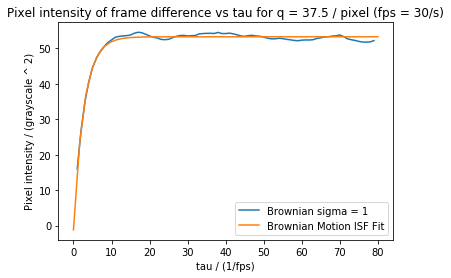

In [42]:
plt.plot(tau_brownian_example_800, brownian_example_800[37.5], label="Brownian sigma = 1")
x = np.linspace(0, 80)
y = brownian_isf(x, *fit(tau_brownian_example_800, brownian_example_800[37.5], brownian_isf)[0])
plt.plot(x, y, label="Brownian Motion ISF Fit")
plt.ylabel("Pixel intensity / (grayscale ^ 2)")
plt.xlabel("tau / (1/fps)")
plt.title("Pixel intensity of frame difference vs tau for q = 37.5 / pixel (fps = 30/s)")
plt.legend(loc="lower right")

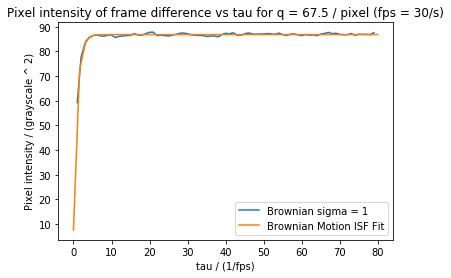

In [41]:
plt.plot(tau_brownian_example_800, brownian_example_800[67.5], label="Brownian sigma = 1")
x = np.linspace(0, 80)
y = brownian_isf(x, *fit(tau_brownian_example_800, brownian_example_800[67.5], brownian_isf)[0])
plt.plot(x, y, label="Brownian Motion ISF Fit")
plt.ylabel("Pixel intensity / (grayscale ^ 2)")
plt.xlabel("tau / (1/fps)")
plt.title("Pixel intensity of frame difference vs tau for q = 67.5 / pixel (fps = 30/s)")
plt.legend(loc="lower right")

In [9]:
tauc_brownian_example_800 = total_fit(tau_brownian_example_800, brownian_example_800)
tauc_brownian_sigma5_800 = total_fit(tau_brownian_sigma5_800, brownian_sigma5_800)
tauc_geometric_brownian_drift_800 = total_fit(tau_geometric_brownian_drift, geometric_brownian_drift_800)

/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/Users/jordan/Library/Python/3.7/lib/python/site-packages/scipy/optimize/_lsq/common.py:237: RuntimeWarning: overflow encountered in double_scalars
  ratio = actual_reduction / predicted_reduction


In [12]:
def plot(data, label):
    plt.plot(np.log(list(data.keys())), np.log(list(data.values())), label=label)

/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


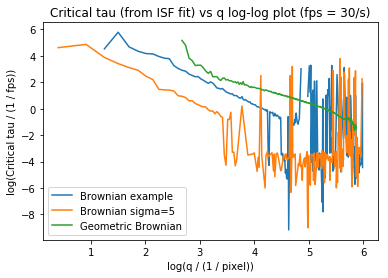

In [35]:
#filter out when error exceeds value

brownian_example_800_fit = remove_large_errors(tauc_brownian_example_800)
plot(brownian_example_800_fit, label="Brownian example")
#filter out when error exceeds value
brownian_sigma5_800_fit = remove_large_errors(tauc_brownian_sigma5_800)
plot(brownian_sigma5_800_fit, label="Brownian sigma=5")
#filter out when error exceeds value
geometric_brownian_drift_800_fit = remove_large_errors(tauc_geometric_brownian_drift_800)
plot(geometric_brownian_drift_800_fit, label="Geometric Brownian")
plt.xlabel("log(q / (1 / pixel))")
plt.ylabel("log(Critical tau / (1 / fps))")
plt.title("Critical tau (from ISF fit) vs q log-log plot (fps = 30/s)")
plt.legend(loc="lower left")

In [14]:
def dict_reduce(dict, q1, q2):
    return {k: v for k, v in dict.items() if np.log(k) > q1 and np.log(k) < q2}

def linear_reg(data):
    x = np.log(list(data.keys()))
    y = np.log(list(data.values()))
    return linregress(x, y)
    

In [15]:
geom_filtered = dict_reduce(geometric_brownian_drift_800_fit, 3, 5.5)
brown_filtered = dict_reduce(brownian_example_800_fit, 1.8, 4)
sigma_filtered = dict_reduce(brownian_sigma5_800_fit, 1, 3.2)

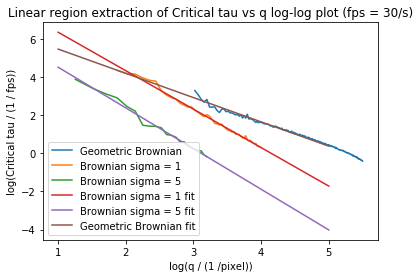

In [45]:
plot(geom_filtered, label="Geometric Brownian")
plot(brown_filtered, label="Brownian sigma = 1")
plot(sigma_filtered, label="Brownian sigma = 5")
x = np.linspace(1, 5)

fit_brown = linear_reg(brown_filtered)
y_brown = fit_brown[0] * x + fit_brown[1]
plt.plot(x, y_brown, label="Brownian sigma = 1 fit")

fit_sigma = linear_reg(sigma_filtered)
y_sigma = fit_sigma[0]*x + fit_sigma[1]
plt.plot(x, y_sigma, label="Brownian sigma = 5 fit")

fit_geom = linear_reg(geom_filtered)
y_geom = fit_geom[0]*x + fit_geom[1]
plt.plot(x, y_geom, label="Geometric Brownian fit")

plt.xlabel("log(q / (1 /pixel))")
plt.ylabel("log(Critical tau / (1 / fps))")
plt.title("Linear region extraction of Critical tau vs q log-log plot (fps = 30/s)")
plt.legend(loc="lower left")

In [37]:
fit_brown, fit_sigma, fit_geom

(LinregressResult(slope=-2.0161010593289452, intercept=8.364304547953203, rvalue=-0.9968532586377802, pvalue=2.1026315246713846e-53, stderr=0.023384911787883905),
 LinregressResult(slope=-2.132238395871636, intercept=6.645952811543188, rvalue=-0.994347772398905, pvalue=5.8673347917654095e-21, stderr=0.05090878398535014),
 LinregressResult(slope=-1.2719077846937044, intercept=6.736483563886818, rvalue=-0.995840551983295, pvalue=5.195255252123864e-234, stderr=0.007792811267613486))